In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, TimestampType

import pyspark.sql.functions as F
from pyspark.sql.functions import udf

master = "local[12]"
app_name = "Parallel Join"
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.executor.memory", "8g")
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()



pd.set_option('display.max_colwidth', None)

23/02/27 20:00:23 WARN Utils: Your hostname, crarojasca-Blade-14-RZ09-0370 resolves to a loopback address: 127.0.1.1; using 192.168.1.10 instead (on interface wlp2s0)
23/02/27 20:00:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/27 20:00:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
file = "../datasets/omm_export_tweets_01-06-2022.csv"
data = spark.read.options(delimiter="\t").csv(file, header=True)
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- fulltext: string (nullable = true)
 |-- 140_char_text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- language: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_time_zone: string (nullable = true)
 |-- user_follower_count: string (nullable = true)
 |-- user_favorite_count: string (nullable = true)
 |-- user_tweet_count: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- media: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: 

In [3]:
data.count()

5236660

In [5]:
schema = StructType([
    StructField("id_cards", StringType(), True),
    StructField("cards_pred", StringType(), True),
    StructField("cards_pred_score", FloatType(), True)])

file = "../datasets/predictions"
predictions = spark.read.options(delimiter="|").csv(file, header=False, schema=schema)
predictions.printSchema()

root
 |-- id_cards: string (nullable = true)
 |-- cards_pred: string (nullable = true)
 |-- cards_pred_score: float (nullable = true)



In [6]:
schema = StructType([
    StructField("id_waterloo_cards", StringType(), True),
    StructField("waterloo_cards_pred", StringType(), True),
    StructField("waterloo_cards_score", FloatType(), True)])

file = "../datasets/predictions_waterloo_cards"
new_predictions = spark.read.options(delimiter="|").csv(file, header=False, schema=schema)
new_predictions.printSchema()

root
 |-- id_waterloo_cards: string (nullable = true)
 |-- waterloo_cards_pred: string (nullable = true)
 |-- waterloo_cards_score: float (nullable = true)



In [7]:
data = data.join(
    predictions, data.id ==  predictions.id_cards, "inner"
)

data = data.join(
    new_predictions, data.id ==  new_predictions.id_waterloo_cards, "inner"
)

data = data.drop(
    "id_cards", "id_waterloo_cards"
)

In [8]:
@udf(returnType=TimestampType())
def generateDate(year, month, day):
    if not year or not month or not day:
        return
    try:
        date = year + "-" + month + "-" + day
        return datetime.strptime(date,"%Y-%m-%d") 
    except:
        return

data = (
    data.withColumn("year", data.year.cast(StringType()))
    .withColumn("month", data.month.cast(StringType()))
    .withColumn("day", data.day.cast(StringType()))
)

data = (
    data.withColumn("date", generateDate(data.year, data.month, data.day))
)

In [9]:
grouped_dates = data.groupby("date").count().toPandas()
grouped_dates = grouped_dates.sort_values(by="date").dropna()

23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:10 WARN RowBasedKeyValueBatch: Calling spill() on

23/02/27 20:02:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Text(0.5, 0, 'Date')

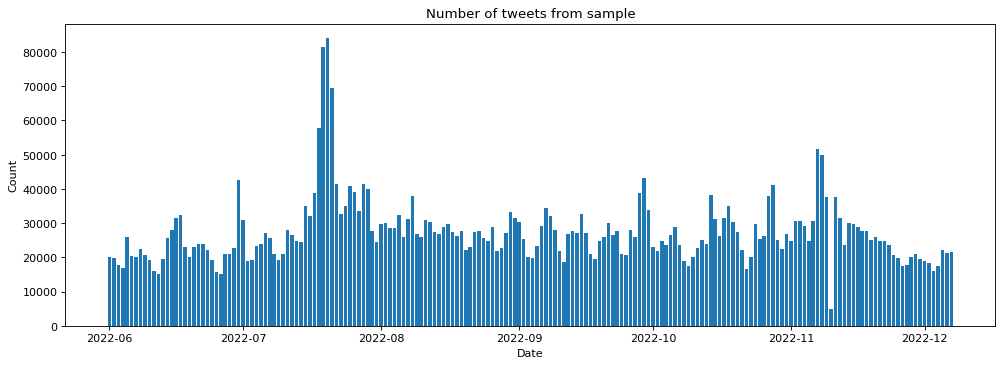

In [10]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.bar(grouped_dates.date, grouped_dates["count"])  # density=False would make counts
plt.title("Number of tweets from sample")
plt.ylabel('Count')
plt.xlabel('Date')

In [38]:
labels = data.select('cards_pred').distinct().toPandas()["cards_pred"].tolist()
labels.remove("0_0")

n = 10000
data_sampled = pd.DataFrame()
for label in labels:
    sample = (
        data.filter(data.cards_pred == label)
        .orderBy("cards_pred_score", ascending=False)
        .limit(n).toPandas()
    )
    data_sampled = pd.concat([data_sampled, sample])
    
data_sampled.to_csv("../datasets/hamburg_misinformation_sampled.csv", index=False)

In [11]:
real_cards = (
    data.filter(data.cards_pred == "0_0").groupby("date")
    .count().toPandas().sort_values(by="date")
    .rename(columns={"count": "standard_cards"})
)

real_waterloo_cards = (
    data.filter(data.waterloo_cards_pred == "0").groupby("date")
    .count().toPandas().sort_values(by="date")
    .rename(columns={"count": "standard_waterloo_cards"})
)

misinformation_cards = (
    data.filter(data.cards_pred != "0_0").groupby("date")
    .count().toPandas().sort_values(by="date")
    .rename(columns={"count": "misinformation_cards"})
)

misinformation_waterloo_cards = (
    data.filter(data.waterloo_cards_pred != "0").groupby("date")
    .count().toPandas().sort_values(by="date")
    .rename(columns={"count": "misinformation_waterloo_cards"})
)

23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on

23/02/27 20:02:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/02/27 20:02:47 WARN RowBasedKeyValueBatch: Calling spill() on

Exception in thread "stdout writer for python3" Exception in thread "stdout writer for python3" Exception in thread "stdout writer for python3" Exception in thread "stdout writer for python3" org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 65536 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:413)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:447)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:485)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIter

23/02/27 20:02:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


ERROR:root:KeyboardInterrupt while sending command.                (5 + 8) / 13]
Traceback (most recent call last):
  File "/opt/conda/envs/uni/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/envs/uni/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/envs/uni/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [13]:
grouped_counts = pd.merge(real_cards, real_waterloo_cards, on="date")
grouped_counts = pd.merge(grouped_counts, misinformation_cards, on="date")
grouped_counts = pd.merge(grouped_counts, misinformation_waterloo_cards, on="date")
# grouped_counts = grouped_counts[~grouped_counts.date.isna()]
# grouped_counts.loc[grouped_counts.standard.isna(), "standard"] = 0
# grouped_counts.loc[grouped_counts.missinformation.isna(), "misinformation"] = 0

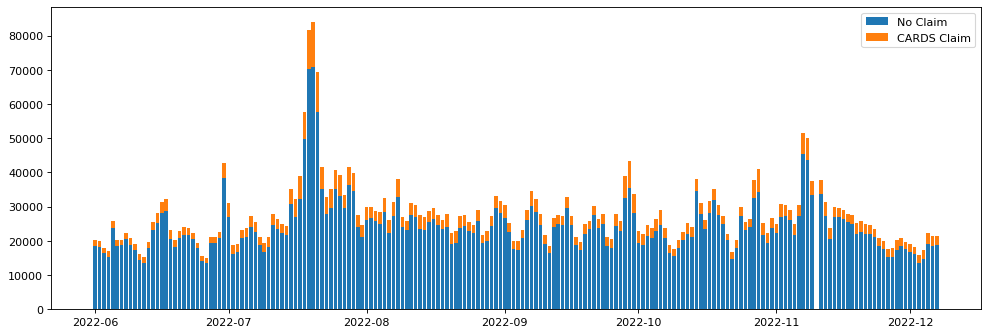

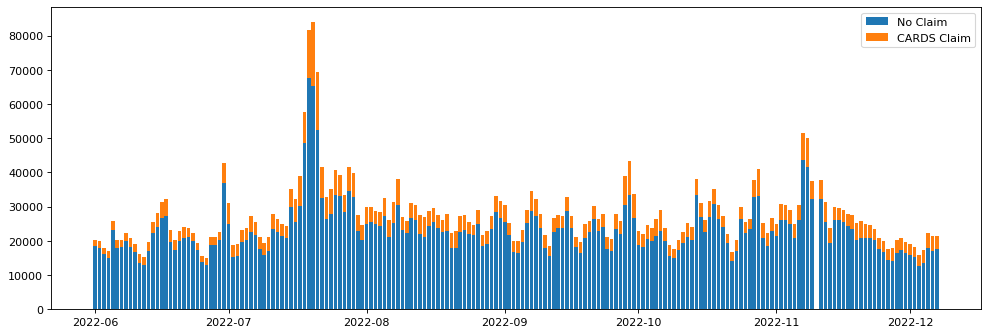

In [14]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=80)
 
ax.bar(grouped_counts.date.values, grouped_counts["standard_cards"].values, label='No Claim')
ax.bar(grouped_counts.date.values, grouped_counts["misinformation_cards"].values, 
       bottom=grouped_counts["standard_cards"].values, label='CARDS Claim')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 5), dpi=80)
 
ax.bar(grouped_counts.date.values, grouped_counts["standard_waterloo_cards"].values, label='No Claim')
ax.bar(grouped_counts.date.values, grouped_counts["misinformation_waterloo_cards"].values, 
       bottom=grouped_counts["standard_waterloo_cards"].values, label='CARDS Claim')
ax.legend()

plt.show()

In [15]:
grouped_counts = pd.merge(grouped_counts, grouped_dates, on="date")

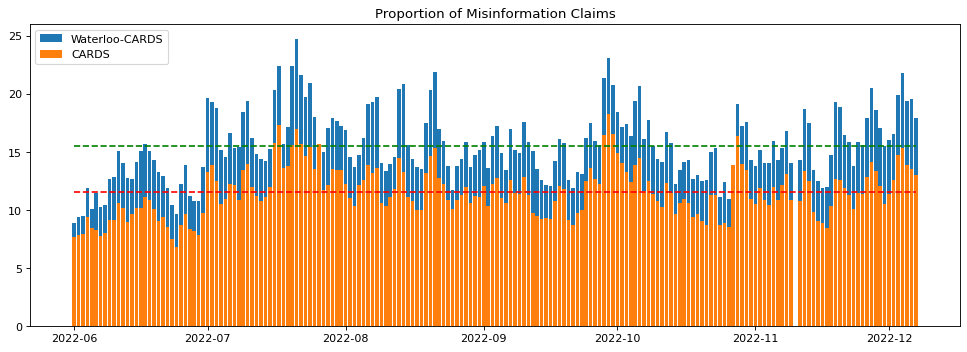

In [16]:
grouped_counts["proportion_cards"] = grouped_counts.misinformation_cards/grouped_counts["count"]*100
grouped_counts["proportion_waterloo_cards"] = (
    grouped_counts.misinformation_waterloo_cards/grouped_counts["count"]*100)

# def plot_misinformation_proportion(x, y, title):
mean_cards = [grouped_counts["proportion_cards"].mean()] * len(grouped_counts)
mean_waterloo_cards = [grouped_counts["proportion_waterloo_cards"].mean()] * len(grouped_counts)
# quantile_1 = [grouped_counts["proportion_cards"].quantile(0.25)] * len(grouped_counts)
# quantile_2 = [grouped_counts["proportion_cards"].quantile(0.75)] * len(grouped_counts)

fig, ax = plt.subplots(figsize=(15, 5), dpi=80)
ax.bar(grouped_counts.date, grouped_counts["proportion_waterloo_cards"], label="Waterloo-CARDS")
ax.bar(grouped_counts.date, grouped_counts["proportion_cards"], label="CARDS")

ax.plot(grouped_counts.date, mean_cards,'r--')
ax.plot(grouped_counts.date, mean_waterloo_cards,'g--')
# ax.plot(grouped_counts.date, quantile_1,'g--')
# ax.plot(grouped_counts.date, quantile_2,'g--')
plt.title("Proportion of Misinformation Claims")
plt.legend(loc="upper left")
plt.show()

In [17]:
data_predictions_date_cards = data.groupby(["date", "cards_pred"]).count().toPandas()
data_predictions_date_waterloo_cards = data.groupby(["date", "waterloo_cards_pred"]).count().toPandas()

data_predictions_date = pd.merge(
    data_predictions_date_cards, data_predictions_date_waterloo_cards, on="date")

23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:52 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:56:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/13 23:57:19 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/13 23:57:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


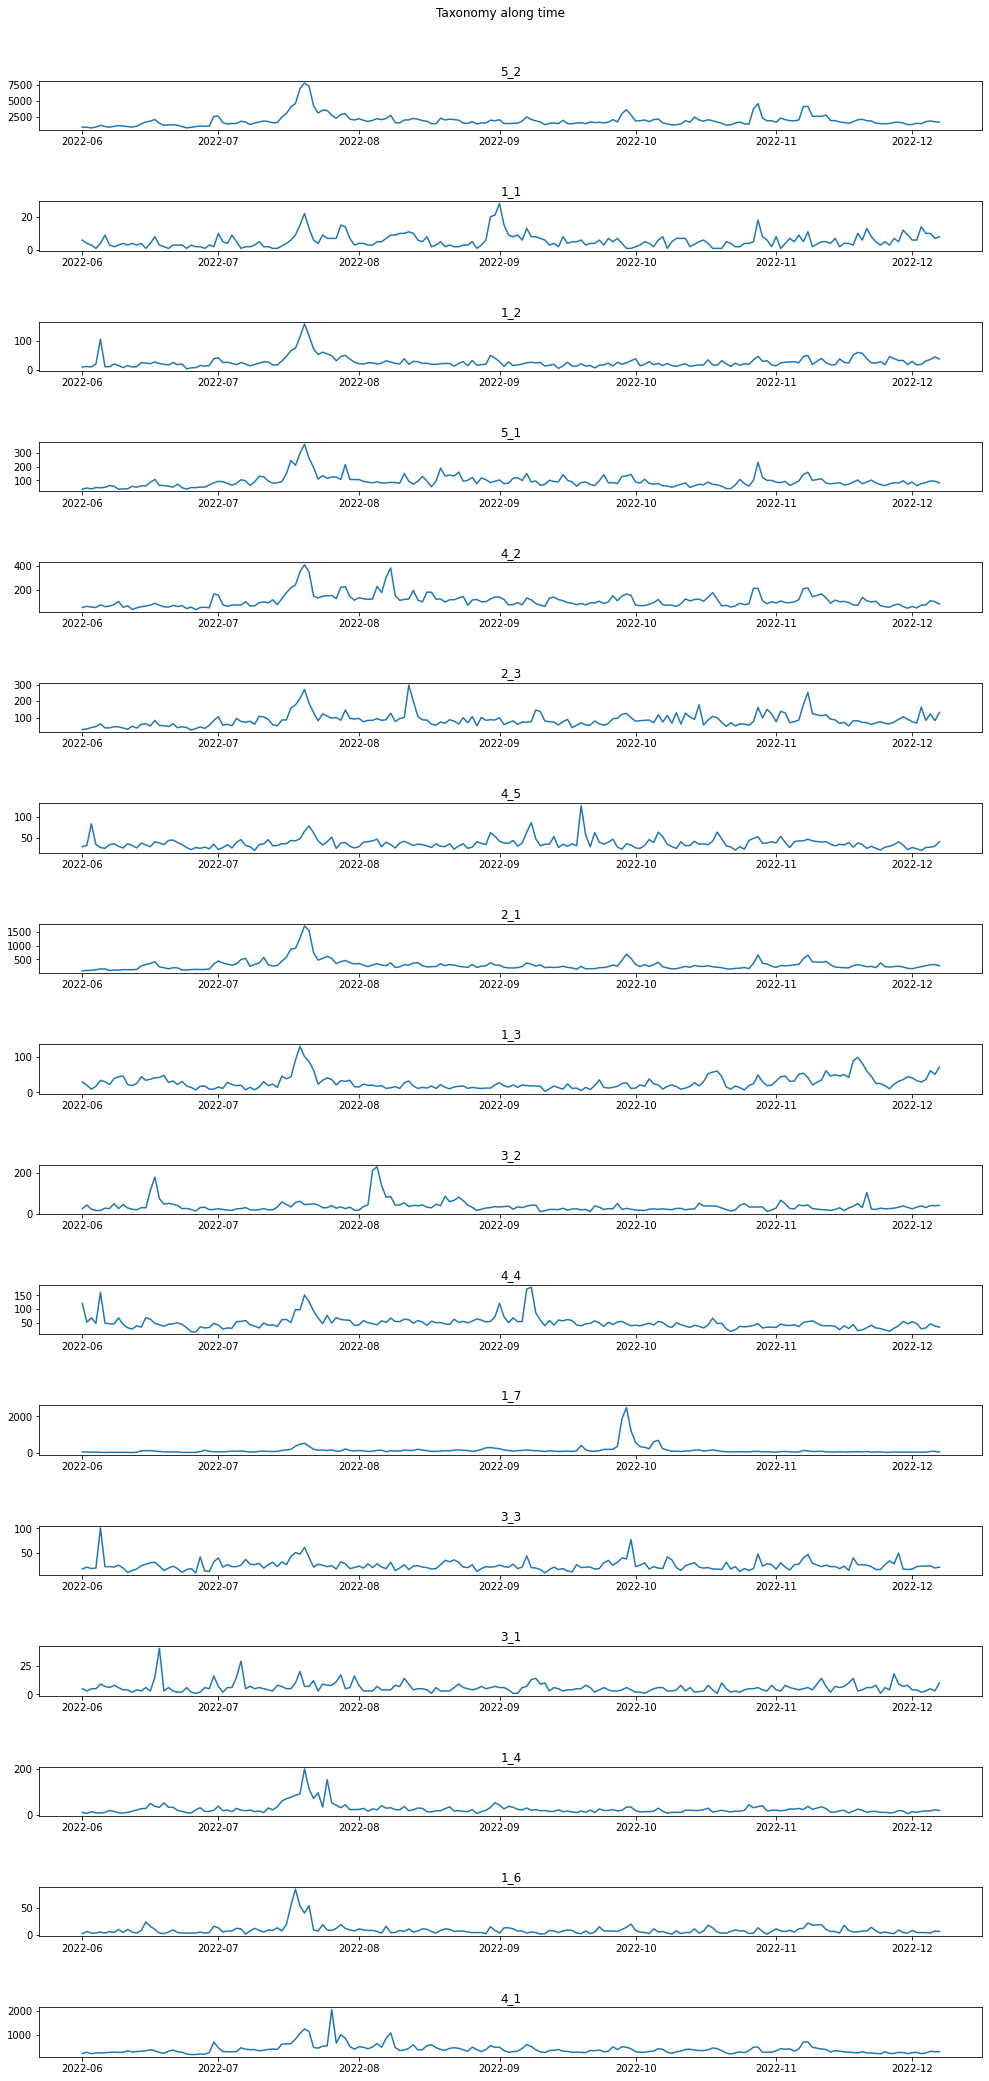

In [102]:
labels = np.delete(data_predictions_date.cards_pred.unique(), -1).tolist()

fig, axs = plt.subplots(len(labels), figsize=(15, 30))
fig.suptitle('Taxonomy along time')
fig.tight_layout(pad=5.0)

for i, label in enumerate(labels):
    subset = (
        data_predictions_date[data_predictions_date.cards_pred == label]
        .sort_values(by="date")
    )
    x = subset.date
    y = subset["count"]
    axs[i].plot(x, y)
    axs[i].set_title(label)

In [18]:
@udf(returnType=StringType())
def getLabel(pred):
    if pred == "0_0":
        return "0"
    return "1"

data = data.withColumn("cards_sum_pred", getLabel(F.col("cards_pred")))

In [19]:
data_predictions_1 = (
    data.groupby("cards_sum_pred").count().toPandas().rename(columns={"count": "cards"})
)
data_predictions_2 = (
    data.groupby("waterloo_cards_pred").count().toPandas()
    .rename(columns={"count": "waterloo-cards"})
)

23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:15 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:17 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:27 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 01:47:28 WARN RowBasedKeyValueBatch: Calling spill() on

In [36]:
data_sampled = data.sample(0.05).toPandas()
data_sampled = data_sampled.sample(1000)
print(data_sampled.value_counts())
data_sampled.to_csv("hamburg_1000_sample.csv")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


Series([], dtype: int64)


In [38]:
data_sampled.waterloo_cards_pred.value_counts()

0    838
1    162
Name: waterloo_cards_pred, dtype: int64

In [41]:
data.columns

['id',
 'username',
 'fulltext',
 '140_char_text',
 'hashtags',
 'url',
 'domain',
 'retweet_count',
 'favorite_count',
 'language',
 'lat',
 'lon',
 'user_id',
 'user_location',
 'user_time_zone',
 'user_follower_count',
 'user_favorite_count',
 'user_tweet_count',
 'user_description',
 'media',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'cards_pred',
 'cards_pred_score',
 'waterloo_cards_pred',
 'waterloo_cards_score',
 'date',
 'cards_sum_pred']

23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:50 WARN RowBasedKeyValueBatch: Calling spill() on

[165.733s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 10.0 (TID 76): Retried waiting for GCLocker too often allocating 2097154 words
23/01/14 02:35:50 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/14 02:35:51 WARN RowBasedKeyValueBat

ERROR:root:Exception while sending command.                        (0 + 6) / 13]
Traceback (most recent call last):
  File "/opt/conda/envs/uni/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/envs/uni/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/uni/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/envs/uni/lib/python3.8/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda

ConnectionRefusedError: [Errno 111] Connection refused

In [20]:
data_predictions = data_predictions_1.join(
    data_predictions_2, data_predictions_1.cards_sum_pred==data_predictions_2.waterloo_cards_pred)

In [21]:
data_predictions = pd.concat([data_predictions_1, data_predictions_2], axis=1)
data_predictions["cards %"] = round(data_predictions["cards"]/data_predictions["cards"].sum() *100, 2)
data_predictions["waterloo-cards %"] = round(
    data_predictions["waterloo-cards"]/data_predictions["waterloo-cards"].sum() *100, 2)
data_predictions[["cards", "cards %", "waterloo-cards", "waterloo-cards %"]]

,cards,cards %,waterloo-cards,waterloo-cards %
0,4619375,88.22,4413012,84.28
1,616625,11.78,822988,15.72


In [22]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- username: string (nullable = true)
 |-- fulltext: string (nullable = true)
 |-- 140_char_text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- language: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_time_zone: string (nullable = true)
 |-- user_follower_count: string (nullable = true)
 |-- user_favorite_count: string (nullable = true)
 |-- user_tweet_count: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- media: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: 

In [23]:
data_improvements = (
    data.filter((data.cards_sum_pred == "0") & (data.waterloo_cards_pred == "1"))
    .select("fulltext", "cards_pred", "cards_pred_score", "waterloo_cards_score").toPandas()
)

In [24]:
data_improvements.sample(10)

,fulltext,cards_pred,cards_pred_score,waterloo_cards_score
70856,"“There is no Climate Emergency”: Hundreds More Sign the World Climate Declaration, Including 20 Professors https://t.co/jOk2n4fsPc #cultofclimate #bbcnews #skynews #itvnews #skynews #c4news #BBCBreakfast #r4today",0_0,0.990478,0.996427
253121,"@CarlSilverman10 @bethsawin Yes we've always had the climate changing on the planet. However there are twice as many people on this globe than were here in the 70s. We humans are creating more and more problems with the climate. In the past the human element in climate change was negligible, not so now!",0_0,0.982085,0.893030
274975,"@ChristyEB8 @RepNikema @POTUS Tax payers are funding Ukraine War, Climate Change Agenda, Abortion on Demand, Indoctrination of our Children, etc.. and now Student Debt? To those that favor this absurdity, what do they think happens when we run out of other people's 💰Money?",0_0,0.998705,0.997071
288067,@GretaThunberg There is no climate crisis you high school dropout. https://t.co/4J2gHlq4JD,0_0,0.993998,0.983847
160240,How the Climate Elite Spread Misery by @BjornLomborg https://t.co/Y744RYuiQd ผ่าน @WSJ,0_0,0.807710,0.997116
207190,@jackshafer @crampell Bored rich white liberals can’t get it through their thick skulls that they are the only people who care about climate change. Voters keep telling them what matters. They keep ignoring voters. Then they blame voters for caring about what matters. https://t.co/UnleTN7LO0,0_0,0.998724,0.997464
203805,"@BennettTomlin If you truly think ""climate change"" and whatever bullshit the rich have brainwashed you with to sell you into a ponzi scheme of green fiscal credits and solar panels, is a bigger threat than energy shortages, then you have no clue. Take a good look at Germany this winter...",0_0,0.965299,0.996131
208782,"""Climate change is not the problem. It is a symptom of the larger problem, which is overshoot of a social species finding a bolus of fossil sunlight and throwing a two-century party.""From Nate Hagens interview with his ex-student Lizzie after The Great Simplification.",0_0,0.975637,0.966820
76523,"@DaveNestor22 FBI was involved, on orders of the President of the United States. Gave them COViD injections at 100x body weight dose. Clotted up like putty IMO""Cow farts/burps is REAL climate emergency source.""In other news: Joe eats a lot of good American beef. Medium rare. Plebs eat bugs.",0_0,0.999570,0.981185
323074,"TIME TO TEST OPRAH'S GUTS, LOYALTY, TRUST, OF THE DEMOCRAT PARTY! JOE PILOT &amp; FETTERMAN CO-PILOT, OPRAH VIP REPRESENTING HOLLYWOOD &amp; MEDIA ON DEMOCRAT ONE WAY INTERNATIONAL TOUR, SELLING MARXIST COMMUNIST SOCIALIST ONE WORLD ORDER CLIMATE CHANGE, ABORTION, POPULATION CONTROL!! https://t.co/IBeBsk0MbV",0_0,0.996444,0.994089


In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(y[i]+200000, i, y[i], ha = 'center')

fig, ax = plt.subplots(figsize=(15, 8), dpi=80)

ax.barh(data_predictions.cards_pred, data_predictions["count"])
# addlabels(data_predictions.cards_pred, data_predictions["count"])
plt.show()

In [105]:
data.loc[data.predictions != "0_0", ["fulltext", "predictions"]].sample(5)

,fulltext,predictions
57281,CLIMATE CHANGE IS REAL and happening now. Yes there have always been heat waves but RECORD HIGHS all over the world is not #heatwave #ClimateEmergency Governments need to stop debating and act. NOW #ClimateCrisis #toohot https://t.co/zHNMfruXco,1_7
141030,Well I knew it!... Climate change is a hoax 😂😂 https://t.co/QMNkYhshhK,5_2
17991,"“After 40 years of ‘climate crisis’ predictions by climate catastrophists, human beings are safer than ever from climate. The climate death rate has decreased by *98%* over the last century.”https://t.co/4C4f2GAOLW",1_7
75673,@ibaird @TimSmithMP @theheraldsun Where's your evidence of climate change? ?????,5_2
171411,@washingtonpost Science does not support that. Climate crisis is a hoax,5_2


In [118]:
data.loc[data.date == "2022-07-20", ["fulltext", "date", "predictions"]].sample(5)

,fulltext,date,predictions
65501,Brutal heatwaves are gripping both Europe and the United States this week and are forecast to dump searing heat on much of China into late August. https://t.co/xvauwnberG,2022-07-20,0_0
62596,Climate Crisis? Not for Joe Manchin. Over 1000 dead in Spain and Portugal https://t.co/W3YVstmHqp,2022-07-20,0_0
63207,21 degrees outside and it’s rained overnight. In July! So much for global warming.,2022-07-20,1_3
64736,@MarkCranfield_ @HowKeen @AndMedh @ProfBillMcGuire @DrJamesEHansen @richardabetts @ScientistsX @Sir_David_King @ClimateBen @JKSteinberger @KevinClimate Please review this material from the Royal Society. https://t.co/q7hkbJZvh6 https://t.co/GSdmtqoXNS,2022-07-20,0_0
65143,"While the rich have the resources to insulate themselves from the worst effects of the climate crisis, workers are left to suffer. While the capitalist class is perfectly happy to count their profits while the world burns, people are uniting to demand action. https://t.co/ilXjWpIjJT",2022-07-20,0_0


In [62]:
data.groupby("labels").count().toPandas()

AnalysisException: Column 'labels' does not exist. Did you mean one of the following? [date, lat, day, lon, url, year, domain, fulltext, hashtags, hour, id, language, media, minute, month, user_id, username, cards_pred, 140_char_text, user_location, cards_sum_pred, favorite_count, retweet_count, cards_pred_score, user_time_zone, user_description, user_tweet_count, waterloo_cards_pred, waterloo_cards_score, user_favorite_count, user_follower_count];
'Aggregate ['labels], ['labels, count(1) AS count#1229L]
+- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, year#259, month#289, day#319, hour#40, ... 7 more fields]
   +- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, year#259, month#289, day#319, hour#40, ... 6 more fields]
      +- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, year#259, month#289, cast(day#39 as string) AS day#319, hour#40, ... 5 more fields]
         +- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, year#259, cast(month#38 as string) AS month#289, day#39, hour#40, ... 5 more fields]
            +- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, cast(year#37 as string) AS year#259, month#38, day#39, hour#40, ... 5 more fields]
               +- Project [id#17, username#18, fulltext#19, 140_char_text#20, hashtags#21, url#22, domain#23, retweet_count#24, favorite_count#25, language#26, lat#27, lon#28, user_id#29, user_location#30, user_time_zone#31, user_follower_count#32, user_favorite_count#33, user_tweet_count#34, user_description#35, media#36, year#37, month#38, day#39, hour#40, ... 5 more fields]
                  +- Join Inner, (id#17 = id_waterloo_cards#103)
                     :- Join Inner, (id#17 = id_cards#97)
                     :  :- Relation [id#17,username#18,fulltext#19,140_char_text#20,hashtags#21,url#22,domain#23,retweet_count#24,favorite_count#25,language#26,lat#27,lon#28,user_id#29,user_location#30,user_time_zone#31,user_follower_count#32,user_favorite_count#33,user_tweet_count#34,user_description#35,media#36,year#37,month#38,day#39,hour#40,minute#41] csv
                     :  +- Relation [id_cards#97,cards_pred#98,cards_pred_score#99] csv
                     +- Relation [id_waterloo_cards#103,waterloo_cards_pred#104,waterloo_cards_score#105] csv
